In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, validation_curve
)
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.externals import joblib
from sklearn.linear_model import SGDClassifier

from scipy import sparse

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
Dtrain = pd.read_csv('Dtrain.csv')
Dtest = pd.read_csv('Dtest.csv')

In [3]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [4]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [5]:
sclr = StandardScaler(copy=True)
sclr2 = StandardScaler(with_mean=False)

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

## Bag of Words

### Loading the data

In [7]:
Dtrain_bow = sparse.load_npz('BOW_train.npz')
Dtest_bow = sparse.load_npz('BOW_test.npz')

In [8]:
yTrain_bow = Dtrain.Polarity
yTest_bow = Dtest.Polarity

### Scaling the data

In [9]:
sclr2.fit(Dtrain_bow)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [10]:
Dtrain_scaled_bow = sclr2.transform(Dtrain_bow)
Dtest_scaled_bow = sclr2.transform(Dtest_bow)

In [11]:
params = {
    'alpha': np.logspace(-6, 10, 50)
}

In [12]:
estimator = SGDClassifier(random_state=42)

In [13]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [14]:
features = Dtrain_scaled_bow
labels = yTrain_bow.apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
grid.fit(features, labels)

In [16]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

,Iter #,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,fit_time,score_time,alpha
16,17,0.953471,0.892137,0.954514,0.904352,0.993870,0.975127,0.973787,0.938407,1.547415,0.128938,0.167683
15,16,0.959932,0.891907,0.962820,0.911392,0.992233,0.965611,0.977299,0.937718,1.562031,0.143764,0.079060
17,18,0.944171,0.887717,0.943446,0.893827,0.995518,0.983576,0.968775,0.936555,1.631719,0.113047,0.355648
14,15,0.963984,0.887434,0.968951,0.915207,0.990288,0.954907,0.979497,0.934635,1.693465,0.109798,0.037276
18,19,0.930151,0.877740,0.927882,0.878948,0.997283,0.991434,0.961320,0.931806,1.623949,0.169118,0.754312


In [17]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

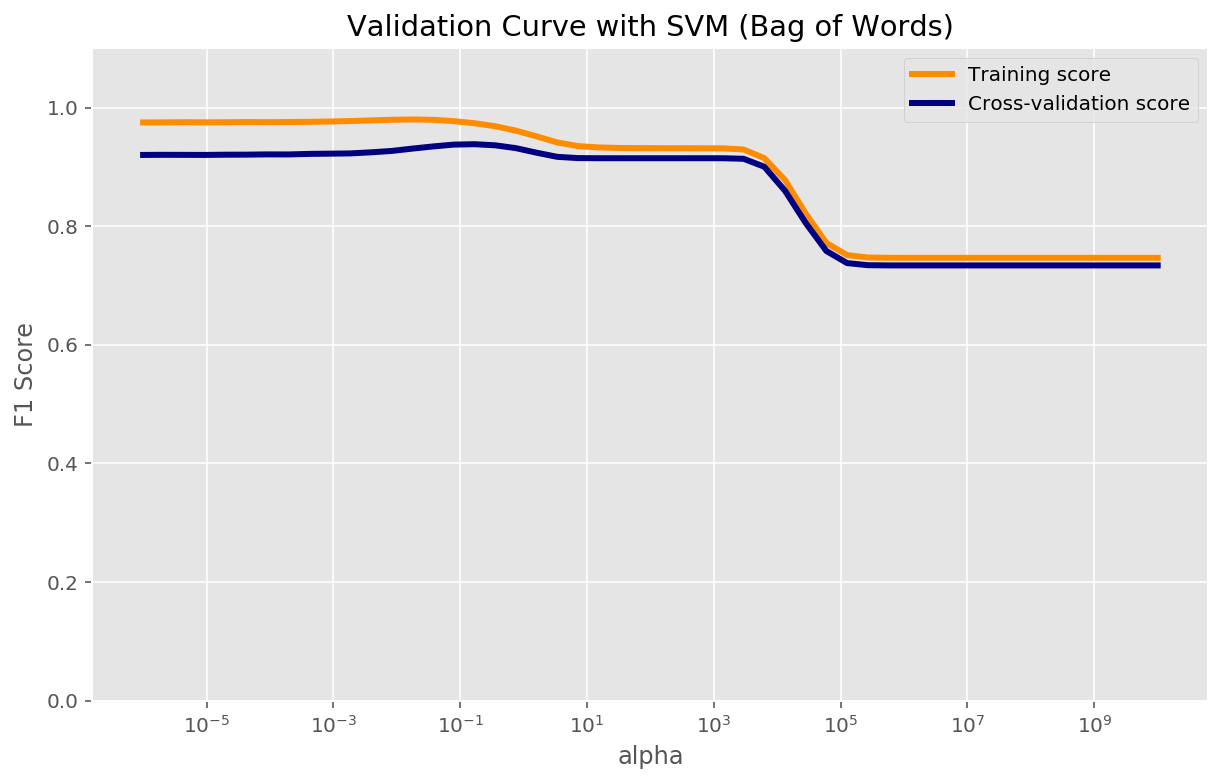

In [19]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM (Bag of Words)")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [20]:
grid.best_estimator_

SGDClassifier(alpha=0.16768329368110066, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [21]:
joblib.dump(grid.best_estimator_, 'bow_best.model')

['bow_best.model']

## TFIDF

### Loading the data

In [22]:
Dtrain_tfidf = sparse.load_npz('tfidf_train.npz')
Dtest_tfidf = sparse.load_npz('tfidf_test.npz')

In [23]:
yTrain_tfidf = Dtrain.Polarity
yTest_tfidf = Dtest.Polarity

### Scaling the data

In [24]:
sclr2.fit(Dtrain_tfidf)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [25]:
Dtrain_scaled_tfidf = sclr2.transform(Dtrain_tfidf)
Dtest_scaled_tfidf = sclr2.transform(Dtest_tfidf)

In [26]:
params = {
    'alpha': np.logspace(-6, 10, 500)
}

In [27]:
estimator = SGDClassifier(random_state=42)

In [28]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    n_iter=50,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [29]:
features = Dtrain_scaled_tfidf
labels = yTrain_tfidf.apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
grid.fit(features, labels)

In [31]:
get_summary_randomized(grid).sort_values('test_f1', ascending=False).head()

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,fit_time,score_time,alpha
48,0.950634,0.884652,0.950939,0.896797,0.994576,0.975370,0.972251,0.934431,1.414185,0.133830,0.226313
38,0.942276,0.880664,0.940978,0.887540,0.996171,0.982920,0.967769,0.932793,1.206708,0.117218,0.379453
17,0.936687,0.876850,0.934611,0.881319,0.997041,0.986709,0.964794,0.931033,1.440087,0.099246,0.509818
43,0.962964,0.881008,0.968073,0.911335,0.990038,0.951426,0.978923,0.930944,1.477790,0.107492,0.051692
24,0.933479,0.874557,0.931105,0.877863,0.997408,0.988665,0.963093,0.929965,1.614511,0.181897,0.590940


In [32]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [33]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

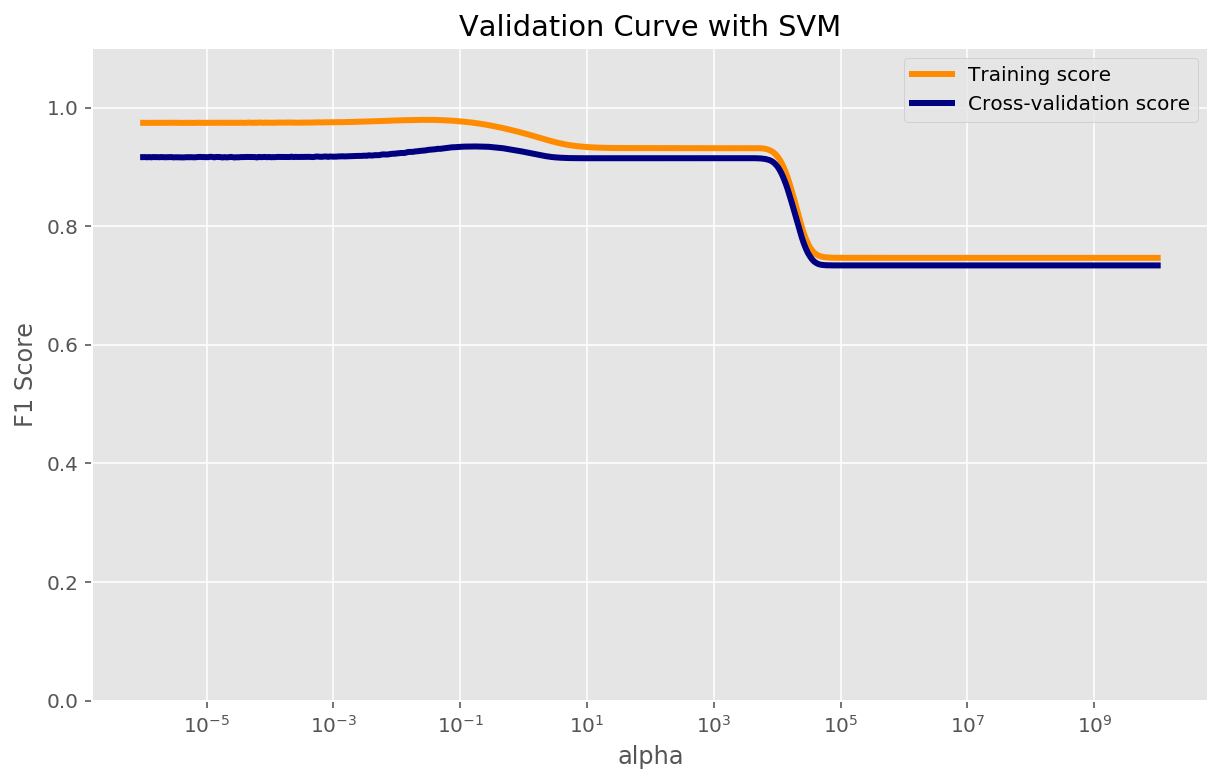

In [34]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [35]:
grid.best_estimator_

SGDClassifier(alpha=0.2263129568399525, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [36]:
joblib.dump(grid.best_estimator_, 'tfidf_best.model')

['tfidf_best.model']

## Avg. Word2Vec

### Loading the data

In [37]:
Dtain_avg_w2v = pd.read_csv('AvgW2V_train.csv')
Dtest_avg_w2v = pd.read_csv('AvgW2V_test.csv')

### Scaling the data

In [38]:
yTrain_avg_w2v = Dtain_avg_w2v.Label
yTest_avg_w2v = Dtest_avg_w2v.Label

Dtain_avg_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_avg_w2v.drop(['Label'], inplace=True, axis=1)

sclr.fit(Dtain_avg_w2v)

Dtrain_scaled_avg_w2v = sclr.transform(Dtain_avg_w2v)
Dtest_scaled_avg_w2v = sclr.transform(Dtest_avg_w2v)

### GridSearch

In [39]:
params = {
    'alpha': np.logspace(-6, 10, 50)
}
estimator = SGDClassifier(random_state=42)

In [40]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [41]:
features = Dtrain_scaled_avg_w2v
labels = yTrain_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
grid.fit(features, labels)

### Interpretation

In [43]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

,Iter #,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,fit_time,score_time,alpha
8,9,0.891618,0.872090,0.902400,0.881452,0.981776,0.979975,0.940394,0.928080,1.553813,0.106452,0.000409
9,10,0.890638,0.870400,0.898560,0.876800,0.985714,0.984465,0.940109,0.927504,1.248759,0.061034,0.000869
7,8,0.889696,0.871182,0.904801,0.884904,0.976132,0.973836,0.939081,0.927196,1.570806,0.131830,0.000193
10,11,0.888971,0.868027,0.894710,0.872255,0.988860,0.987996,0.939429,0.926520,1.339635,0.072962,0.001842
6,7,0.886905,0.868592,0.909092,0.889534,0.967025,0.963947,0.937089,0.925149,1.176300,0.125300,0.000091


In [44]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [45]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

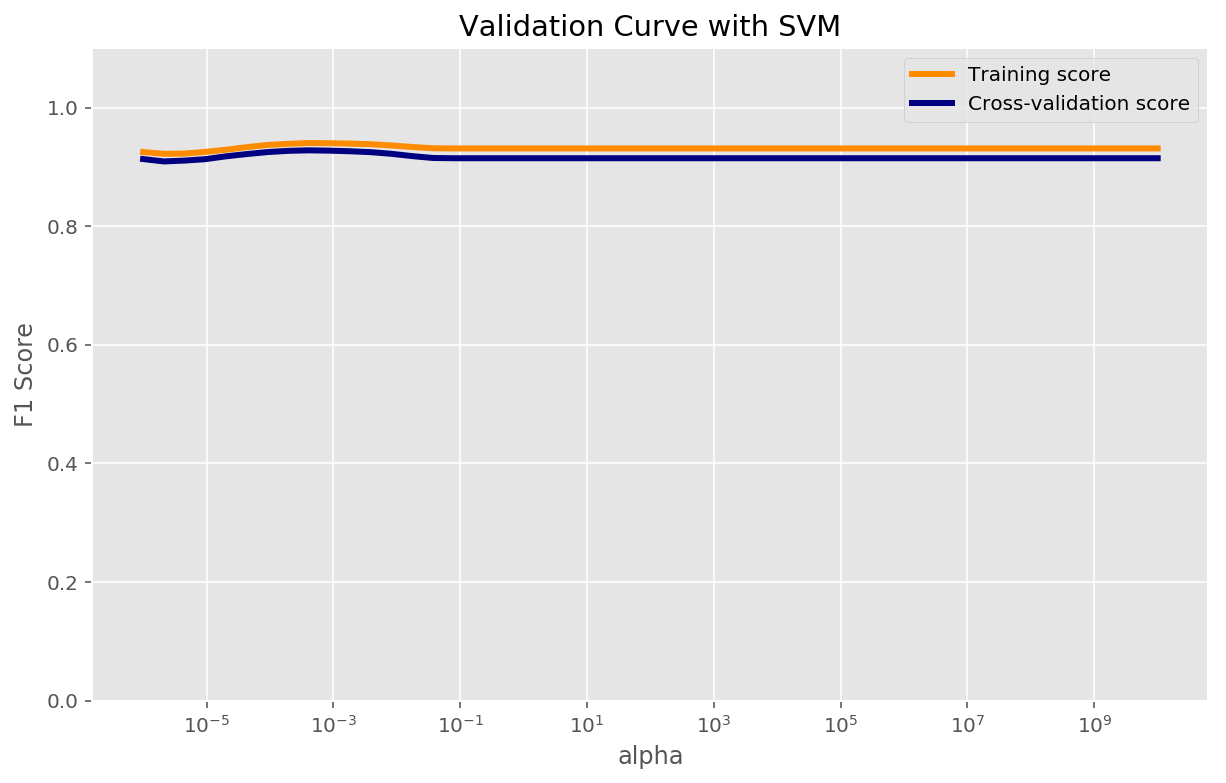

In [46]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [47]:
grid.best_estimator_

SGDClassifier(alpha=0.0004094915062380423, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

#### Saving the best estimator

In [48]:
joblib.dump(grid.best_estimator_, 'avgW2V_best.model')

['avgW2V_best.model']

## TFIDF Word2Vec

### Loading the data

In [49]:
Dtain_tfidf_w2v = pd.read_csv('TFIDF_w2v_train.csv')
Dtest_tfidf_w2v = pd.read_csv('TFIDF_w2v_test.csv')

### Scaling the data

In [50]:
yTrain_TFIDF_w2v = Dtain_tfidf_w2v.Label
yTest_TFIDF_w2v = Dtest_tfidf_w2v.Label
Dtain_tfidf_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_tfidf_w2v.drop(['Label'], inplace=True, axis=1)

sclr.fit(Dtain_tfidf_w2v)

Dtrain_scaled_TFIDF_w2v = sclr.transform(Dtain_tfidf_w2v)
Dtest_scaled_TFIDF_w2v = sclr.transform(Dtest_tfidf_w2v)

### RandomizedSearch

In [51]:
params = {
    'alpha': np.logspace(-6, 10, 500)
}
estimator = SGDClassifier(random_state=42)

In [52]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8,
                    n_iter=50)

In [53]:
features = Dtrain_scaled_TFIDF_w2v
labels = yTrain_TFIDF_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
grid.fit(features, labels)

### Interpretation

In [55]:
get_summary_randomized(grid).sort_values('test_f1', ascending=False).head()

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,fit_time,score_time,alpha
36,0.898322,0.881384,0.911461,0.894808,0.978268,0.973623,0.943676,0.932540,2.494097,0.150695,0.000494
11,0.897710,0.880730,0.912142,0.895029,0.976649,0.972489,0.943268,0.932116,2.531969,0.124069,0.000317
15,0.897445,0.879779,0.907759,0.890328,0.982012,0.977688,0.943422,0.931956,2.331313,0.110093,0.000959
27,0.897357,0.879619,0.907792,0.890391,0.981849,0.977378,0.943366,0.931851,2.450092,0.129692,0.001033
2,0.897016,0.879233,0.906680,0.889203,0.982891,0.978530,0.943246,0.931722,2.250007,0.118333,0.001289


In [56]:
alphas = grid.cv_results_['param_alpha'].data

In [57]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=alphas,
    cv=tscv, scoring="f1", n_jobs=8)

In [58]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

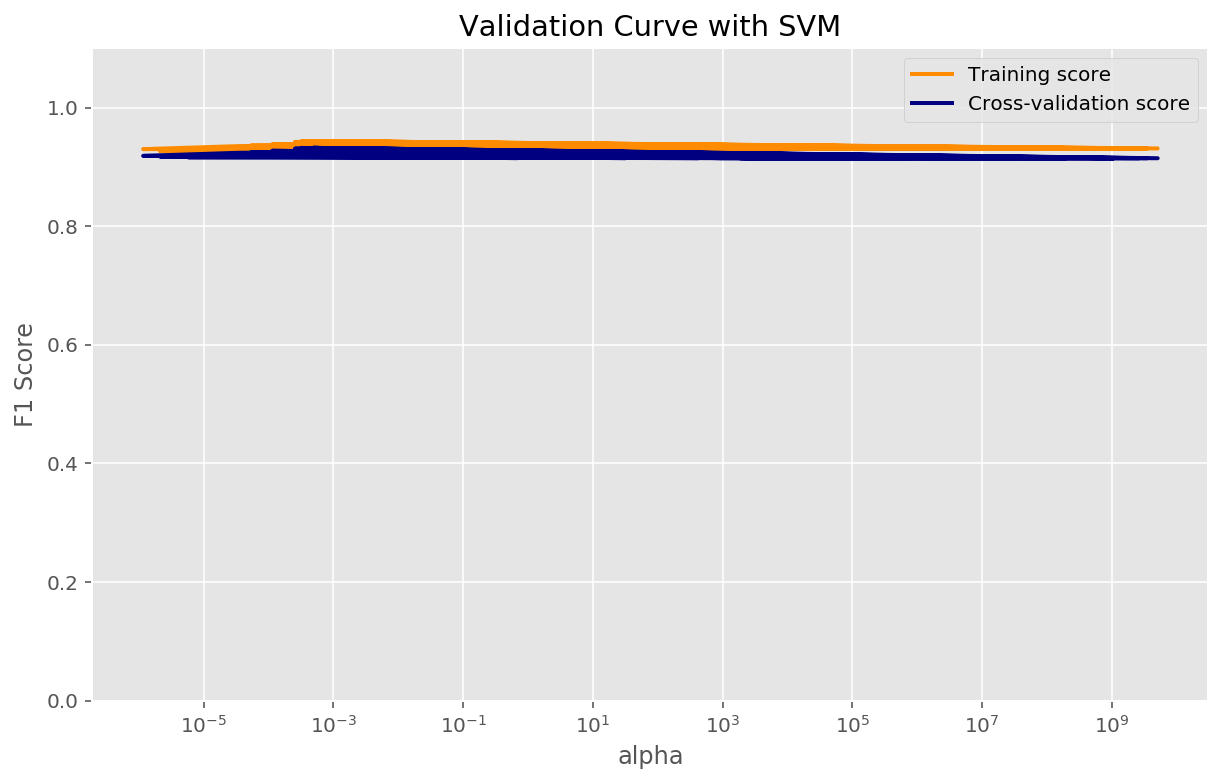

In [59]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(alphas, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(alphas, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [60]:
grid.best_estimator_

SGDClassifier(alpha=0.0004936132098237912, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [61]:
joblib.dump(grid.best_estimator_, 'tfidfW2V_best.model')

['tfidfW2V_best.model']

In [62]:
!ls *.model

avgW2V_best.model  countVectorizer.model  tfidfW2V_best.model
bog_best.model	   tfidf_best.model
bow_best.model	   tfidfVectorizer.model


## Reporting Evaluation metrics for best estimator accoring to F1 score

In [63]:
clf_bow = joblib.load('bow_best.model')
clf_tfidf = joblib.load('tfidf_best.model')
clf_avg_w2v = joblib.load('avgW2V_best.model')
clf_tfidf_w2v = joblib.load('tfidfW2V_best.model')

In [64]:
xTest_bow = Dtest_scaled_bow
actuals_bow = yTest_bow.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf = Dtest_scaled_tfidf
actuals_tfidf = yTest_tfidf.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_avg_w2v = Dtest_scaled_avg_w2v
actuals_avg_w2v = yTest_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf_w2v = Dtest_scaled_TFIDF_w2v
actuals_tfidf_w2v = yTest_TFIDF_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [65]:
preds_bow = clf_bow.predict(xTest_bow)
preds_tfidf = clf_tfidf.predict(xTest_tfidf)
preds_avg_w2v = clf_avg_w2v.predict(xTest_avg_w2v)
preds_tfidf_w2v = clf_tfidf_w2v.predict(xTest_tfidf_w2v)

In [66]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [67]:
acs_bow = accuracy_score(actuals_bow, preds_bow)
acs_tfidf = accuracy_score(actuals_tfidf, preds_tfidf)
acs_avg_w2v = accuracy_score(actuals_avg_w2v, preds_avg_w2v)
acs_tfidf_w2v = accuracy_score(actuals_tfidf_w2v, preds_tfidf_w2v)


pre_bow = precision_score(actuals_bow, preds_bow)
pre_tfidf = precision_score(actuals_tfidf, preds_tfidf)
pre_avg_w2v = precision_score(actuals_avg_w2v, preds_avg_w2v)
pre_tfidf_w2v = precision_score(actuals_tfidf_w2v, preds_tfidf_w2v)


rec_bow = recall_score(actuals_bow, preds_bow)
rec_tfidf = recall_score(actuals_tfidf, preds_tfidf)
rec_avg_w2v = recall_score(actuals_avg_w2v, preds_avg_w2v)
rec_tfidf_w2v = recall_score(actuals_tfidf_w2v, preds_tfidf_w2v)


f1_bow = f1_score(actuals_bow, preds_bow)
f1_tfidf = f1_score(actuals_tfidf, preds_tfidf)
f1_avg_w2v = f1_score(actuals_avg_w2v, preds_avg_w2v)
f1_tfidf_w2v = f1_score(actuals_tfidf_w2v, preds_tfidf_w2v)

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1']
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow])
x.add_row(['TFIDF', acs_tfidf, pre_tfidf, rec_tfidf, f1_tfidf])
x.add_row(['Avg. W2V', acs_avg_w2v, pre_avg_w2v, rec_avg_w2v, f1_avg_w2v])
x.add_row(['TFIDF W2V', acs_tfidf_w2v, pre_tfidf_w2v, rec_tfidf_w2v, f1_tfidf_w2v])
print(x)

+---------------+--------------------+--------------------+--------------------+--------------------+
| Vectorization |      Accuracy      |     Precision      |       Recall       |         F1         |
+---------------+--------------------+--------------------+--------------------+--------------------+
|      BOW      | 0.890548903291955  | 0.9037794299876084 | 0.9707409050576753 | 0.9360641711229947 |
|     TFIDF     | 0.8810648504156139 | 0.8941728132725824 | 0.9707963620230701 | 0.9309105218935791 |
|    Avg. W2V   | 0.8652641986158409 | 0.8733186186691477 | 0.9787139640389116 | 0.9230173757492703 |
|   TFIDF W2V   | 0.8731370610421473 | 0.8839978659794853 | 0.9741106785131942 | 0.926869168742348  |
+---------------+--------------------+--------------------+--------------------+--------------------+


In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
cm_bow = pd.DataFrame(confusion_matrix(actuals_bow, preds_bow),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf = pd.DataFrame(confusion_matrix(actuals_tfidf, preds_tfidf),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_avg_w2v = pd.DataFrame(confusion_matrix(actuals_avg_w2v, preds_avg_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf_w2v = pd.DataFrame(confusion_matrix(actuals_tfidf_w2v, preds_tfidf_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

#### Bag Of Words

In [70]:
cm_bow

,negative,positive
negative,9758,9318
positive,2638,87522


#### TFIDF

In [71]:
cm_tfidf

,negative,positive
negative,8717,10359
positive,2633,87527


#### Avg, W2V

In [72]:
cm_avg_w2v

,negative,positive
negative,6284,12799
positive,1919,88234


#### TFIDF W2V

In [73]:
cm_tfidf_w2v

,negative,positive
negative,7559,11524
positive,2334,87819
